In [ ]:
import scipy, numpy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

This class is just an introduction focusing on intuitive understanding of some aspects of spectral graph properties. There are many ressources online to enter in much more details, for instance:

* http://timroughgarden.org/s17/l/l11.pdf
* https://www.youtube.com/watch?v=01AqmIU9Su4
* https://www.epfl.ch/labs/dcg/wp-content/uploads/2018/10/ADM-Eigenvalues-v3.pdf

Generate a random graph and get its adjacency matrix

In [ ]:
g =nx.random_graphs.barabasi_albert_graph(7,5)

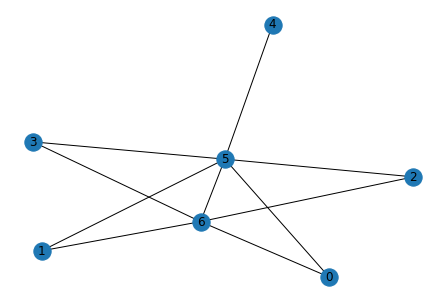

In [ ]:
nx.draw(g, with_labels = True)

# Adjacency matrix
Let's look at the adjacency matrix. Node 0 correpsonds to row (and column) 0, Node 1 corresponds to row (and column) 1, etc.

In [ ]:
A = nx.to_numpy_matrix(g)
A

matrix([[0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0.]])

What happens if we take the square of the matrix ?
Values on the diagonal corresponds to degrees, and $A_{ij}$ corresponds to the number of path of lenght exactly 2 between i and j

In [ ]:
A*A

matrix([[2., 2., 2., 2., 1., 1., 1.],
        [2., 2., 2., 2., 1., 1., 1.],
        [2., 2., 2., 2., 1., 1., 1.],
        [2., 2., 2., 2., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 6., 4.],
        [1., 1., 1., 1., 1., 4., 5.]])

# Eigenvectors/eigenvalues.

I won't enter in too much details on what eigenvectors/eigenvalues are mathematically, I'll just explain the minimum to understand what is happening next. Of course, fill free to read more on the topic if you're interested.

Eigenvectors and eigenvalues come in pairs. When we compute eigenvalues as shown below, the i-th eigenvalue corresponds to the i-th eigenvectors.

In [ ]:
eigvalues,eigvectors = numpy.linalg.eig(A)
[round(x.real,3) for x in eigvalues] #plot all eigenvalues in a readable format

[3.461, -2.471, -1.339, 0.349, -0.0, -0.0, 0.0]

Let's check the definition (and first property) of eigenvalues:

 $Ax = \lambda x$

  with x an eigenvector, and $\lambda$ and eigenvalue

In [ ]:
eig_index=1 #index of the eigenvector/eigenvalue we want to select
eigenvector = eigvectors[:,eig_index]
eigenvalue = eigvalues[eig_index]
print("Ax:")
print(A*eigenvector)
print("eigenvalue x eigenvector:")
print(eigenvalue*eigenvector)

Ax:
[[ 0.90440308]
 [ 0.90440308]
 [ 0.90440308]
 [ 0.90440308]
 [ 0.52428303]
 [-1.29575566]
 [-0.93945956]]
eigenvalue x eigenvector:
[[ 0.90440308]
 [ 0.90440308]
 [ 0.90440308]
 [ 0.90440308]
 [ 0.52428303]
 [-1.29575566]
 [-0.93945956]]


Another way to see things is the relation 

$A-\lambda I x =0$ 

(Nearly 0 due to approximations...)

In [ ]:
a = (A-eigenvalue*numpy.identity(len(eigenvector)))*eigenvector
a = list(numpy.transpose(a))
print([numpy.round(x,4) for x in a])

[array([[-0., -0., -0., -0., -0.,  0.,  0.]])]


Another important property is that eigenvectors are orthogonal:

In [ ]:
print(eigvectors[:,1].T*eigvectors[:,2])
print(eigvectors[:,0].T*eigvectors[:,3])
print(eigvectors[:,3].T*eigvectors[:,4])

[[3.05311332e-16]]
[[2.77555756e-17]]
[[-1.52655666e-16]]


Let's try to get a better intuition of what all these things mean.

We draw the graph corresponding to the second eigenvalue, considering that:
 
* The eigenvalue defines the strengh of a self-loop from each node to itself
* Each value of the corresponding eigenvector gives a score to each node

(self loop represented as a red value on the node)

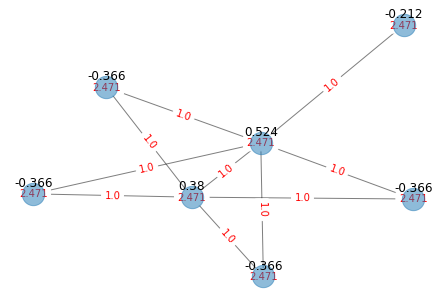

In [ ]:
plt.figure()    
g_to_plot = nx.from_numpy_array(A-eigenvalue*numpy.identity(7))
pos = nx.spring_layout(g_to_plot)
nx.draw(g_to_plot,pos=pos,edge_color='black',width=1,linewidths=1,\
node_size=500,alpha=0.5)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)
nx.draw_networkx_labels(g_to_plot, pos_attrs, labels={i:round(eigenvector[i].item(0),3) for i in range(len(eigenvector))})

nx.draw_networkx_edge_labels(g_to_plot,pos=pos,edge_labels={k:round(v,3) for k,v in nx.get_edge_attributes(g_to_plot,'weight').items()},font_color='red')
plt.axis('off')
plt.show()

A good way to interpret an eigenvector now, is to say that it defines a stability point of the graph based on its structure: 

If each node "sends" to its neighbors (including itself) a value corresponding to the edge weight*its personal score (eigenvector component), then the score of each node will be 0. You can check it manually for 1 node on the graph above

This also allows to have some intuition on what's happening: nodes connected to exactly the same nodes will have the same eigenvector component (you can check above, too)

Some propreties of the eigenvalues of the adjacency matrix are quite interesting, here is a (non-exaustive) list:

* The largest eigenvalue λ1 of a graph G lies between the average and maximum degrees
* The number of closed walks of length k in G equals $\sum_{i=1}^n \lambda^k_i$
* A graph is bipartite if and only if its spectrum is symmetric (ie if λ is an eigenvalue, then so is −λ, and with the same multiplicity).
* If G is connected, then the diameter of G is strictly less than its number of distinct eigenvalues



## Let's introduce the Laplacian

Although some properties of the eigenvalues of the adjacencey matrix are interesting, most practical usages use a variation of it called the *Laplacian*. As we will see, properties of the Laplacian are even more powerful and its interpretation might also be easier

First, let's define $D$, the "degree matrix":

Each value on the diagonal is the degree of the corresponding node, other values are 0

In [ ]:
d = numpy.sum(A,axis=0)
D = numpy.diag(d.tolist()[0])

The laplacian is simply defined as $D-A$

In [ ]:
L = D-A
L

matrix([[ 1.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  2.,  0.,  0.,  0., -1., -1.],
        [ 0.,  0.,  2.,  0.,  0., -1., -1.],
        [ 0.,  0.,  0.,  2.,  0., -1., -1.],
        [ 0.,  0.,  0.,  0.,  2., -1., -1.],
        [-1., -1., -1., -1., -1.,  6., -1.],
        [ 0., -1., -1., -1., -1., -1.,  5.]])

Let's go back to the definition of what eigenvectors are:

$Lx = \lambda x$

Or said differently, $x^TLx = \lambda$

Now we can see something interesting: 
We have a relation $Lv = w$, wich can interpreted as:

(1) $w(i) =􏰂 \sum_{j :(i,j )∈E}(v(i) − v(j))$

and

(2) $\lambda = v^TLv = \sum_{i<j :(i,j )∈E}(v(i) − v(j))^2$

We can see from this relation that the  **eigenvalues are meaningful**: The smaller the eigenvalue, the more adjacent nodes will have the same value in the corresponding eigenvector.


It can be proven that **there are as many eigenvalues equal to 0 as connected components of the graph**. Let's see an intuition of the reason why:

If all adjacent nodes have the same value (in the eigenvector), then equation (2) can be qual to 0. There is therefore always at least one eigenvalue = 0 correspondant to this case (Note: the definition of eigenvalues say that one cannot be a simple multiple of the other, so, for instance, the eigenvectors [1 1 1] and [2 2 2] are in fact the same.

For each additional connected component, there is another different possible eigenvector of eigenvalue 0: it has all the nodes of this addition connected component having the same value, different from the values of all other connected components.


Intuitively, to give an interpretation based on diffusion, we can see that while each node $i$ "sends" $-\lambda v_i$ to each of its neighbor, and that each node "sends" $d_i \lambda v_i$ to himself, if the $v_i$ between all adjacent nodes are equal, all values will annulate themselves (substract one per neighbor, add the degree).

Note that the solution with all elements of the eigenvector having the same value is one trivial solution to have $\lambda=0$, but not necessarily the only one. 





In [ ]:
eigvalues,eigvectors = numpy.linalg.eig(L)
[round(x.real,3) for x in eigvalues]

[7.0, 1.0, -0.0, 2.0, 6.0, 2.0, 2.0]

Because there is a single 0 eigenvalue, we know that there is a single connected component in the graph. 

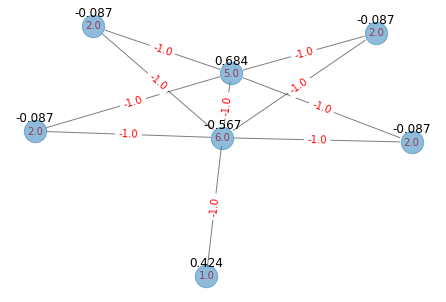

In [ ]:
ith_eigen = 2
eigenvec = eigvectors[:,ith_eigen]
eigenval = eigvalues[ith_eigen]

plt.figure()    
g_pos = nx.from_numpy_array(A)
pos = nx.spring_layout(g_pos)
g_to_plot = nx.from_numpy_array(L)

nx.draw(g_to_plot,pos=pos,edge_color='black',width=1,linewidths=1,\
node_size=500,alpha=0.5)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)
nx.draw_networkx_labels(g_to_plot, pos_attrs, labels={i:round(eigenvec[i].item(0),3) for i in range(len(eigenvec))})

nx.draw_networkx_edge_labels(g_to_plot,pos=pos,edge_labels={k:round(v,3) for k,v in nx.get_edge_attributes(g_to_plot,'weight').items()},font_color='red')
plt.axis('off')
plt.show()

In [ ]:
eigvectors[:,]

matrix([[ 1.61302468e-01,  8.65608378e-01,  4.23914128e-01,
          2.12133124e-01,  2.69291973e-16,  4.62885872e-17,
          5.48134811e-18],
        [ 3.12156849e-01, -1.05211754e-01, -8.70614203e-02,
          3.65935647e-01,  2.88675135e-01, -5.53530785e-01,
         -7.54490869e-01],
        [ 3.12156849e-01, -1.05211754e-01, -8.70614203e-02,
          3.65935647e-01, -8.66025404e-01,  1.27680853e-01,
          1.51195629e-02],
        [ 3.12156849e-01, -1.05211754e-01, -8.70614203e-02,
          3.65935647e-01,  2.88675135e-01,  7.54509302e-01,
          8.93466054e-02],
        [ 3.12156849e-01, -1.05211754e-01, -8.70614203e-02,
          3.65935647e-01,  2.88675135e-01, -3.28659370e-01,
          6.50024701e-01],
        [ 5.58246439e-01,  3.02379305e-01, -5.67498874e-01,
         -5.24283031e-01, -2.41016702e-33, -4.36851474e-32,
         -9.15894287e-33],
        [ 5.22086999e-01, -3.39132481e-01,  6.84049031e-01,
         -3.80120047e-01, -2.18313502e-16, -4.91633736e-17

The normalized Laplacian is a variant defined as 

$D^{1/2}LD^{1/2}$

In [ ]:
Lnorm = numpy.power(D,1/2)*L*numpy.power(D,1/2)
Lnorm

matrix([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -2.44948974,  0.        ],
        [ 0.        ,  4.        ,  0.        ,  0.        ,  0.        ,
         -3.46410162, -3.16227766],
        [ 0.        ,  0.        ,  4.        ,  0.        ,  0.        ,
         -3.46410162, -3.16227766],
        [ 0.        ,  0.        ,  0.        ,  4.        ,  0.        ,
         -3.46410162, -3.16227766],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  4.        ,
         -3.46410162, -3.16227766],
        [-2.44948974, -3.46410162, -3.46410162, -3.46410162, -3.46410162,
         36.        , -5.47722558],
        [ 0.        , -3.16227766, -3.16227766, -3.16227766, -3.16227766,
         -5.47722558, 25.        ]])

In [ ]:
G= nx.karate_club_graph()

In [ ]:
A = nx.to_numpy_matrix(G)

In [ ]:
d = numpy.sum(A,axis=0)

In [ ]:
D = numpy.diag(d.tolist()[0])

In [ ]:
L = D-A

In [ ]:
L

matrix([[16., -1., -1., ..., -1.,  0.,  0.],
        [-1.,  9., -1., ...,  0.,  0.,  0.],
        [-1., -1., 10., ...,  0., -1.,  0.],
        ...,
        [-1.,  0.,  0., ...,  6., -1., -1.],
        [ 0.,  0., -1., ..., -1., 12., -1.],
        [ 0.,  0.,  0., ..., -1., -1., 17.]])

In [ ]:
numpy.linalg.eig(A)

(array([ 6.72569773e+00+0.00000000e+00j,  4.97707423e+00+0.00000000e+00j,
        -4.48722919e+00+0.00000000e+00j, -3.44793486e+00+0.00000000e+00j,
        -3.11069092e+00+0.00000000e+00j,  2.91650670e+00+0.00000000e+00j,
        -2.43742443e+00+0.00000000e+00j,  2.30908767e+00+0.00000000e+00j,
        -2.09082295e+00+0.00000000e+00j, -1.68768945e+00+0.00000000e+00j,
        -1.44407374e+00+0.00000000e+00j, -1.19242425e+00+0.00000000e+00j,
        -1.04208785e+00+0.00000000e+00j, -7.92406815e-01+0.00000000e+00j,
        -4.18818748e-01+0.00000000e+00j,  1.48615954e+00+0.00000000e+00j,
         1.45305566e+00+0.00000000e+00j,  1.08328639e+00+0.00000000e+00j,
         1.03145042e+00+0.00000000e+00j,  8.34304102e-01+0.00000000e+00j,
         2.99410685e-01+0.00000000e+00j,  4.19729474e-01+0.00000000e+00j,
         6.15840589e-01+0.00000000e+00j, -2.00000000e+00+0.00000000e+00j,
        -1.84096457e-16+0.00000000e+00j,  3.25975263e-16+0.00000000e+00j,
         1.19978798e-16+1.01484071e-16

In [ ]:
numpy.linalg.eig(L)

(array([ 1.81366960e+01,  1.70551712e+01,  1.33061223e+01,  1.09210675e+01,
         9.77724095e+00,  6.99619703e+00,  6.51554463e+00,  6.33159222e+00,
        -3.03715976e-15,  5.37859508e+00,  4.68525227e-01,  4.58079267e+00,
         4.48000767e+00,  4.27587682e+00,  9.09247664e-01,  1.12501072e+00,
         1.25940411e+00,  1.59928308e+00,  1.76189862e+00,  1.82605521e+00,
         1.95505045e+00,  2.48709173e+00,  2.74915718e+00,  3.01396297e+00,
         3.24206748e+00,  3.47218740e+00,  5.61803399e+00,  3.37615409e+00,
         2.00000000e+00,  3.38196601e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00]),
 matrix([[ 1.93749031e-01, -9.40932167e-01, -9.47825261e-02, ...,
           1.67168731e-16, -3.69951351e-17,  7.31283825e-17],
         [ 5.22422164e-03,  6.58647640e-02,  9.91845054e-02, ...,
          -1.14645366e-16,  5.13980456e-17, -1.90723045e-17],
         [ 2.91860881e-02,  1.15069117e-01, -3.14797911e-01, ...,
           4.37720638e-16,

In [ ]:
numpy.linalg.eig(Lnorm)

(array([2.93335118e+02, 2.60684041e+02, 1.48650139e+02, 1.03787051e+02,
        8.15809267e+01, 3.89268998e+01, 3.66121642e+01, 2.87960331e+01,
        2.58350221e+01, 2.15573089e+01, 1.68124716e+01, 1.47089000e+01,
        1.39545841e+01, 1.29292100e+01, 1.56164966e-14, 1.10365428e+01,
        8.39638608e+00, 7.41259682e+00, 9.28698189e-01, 1.40554881e+00,
        5.03272597e+00, 2.54720899e+00, 3.36129473e+00, 3.77711648e+00,
        3.58348273e+00, 3.63970570e+00, 2.12915026e+01, 1.07088228e+01,
        1.07084974e+01, 4.00000000e+00, 4.00000000e+00, 4.00000000e+00,
        4.00000000e+00, 4.00000000e+00]),
 matrix([[-2.91508563e-02,  9.89343482e-01, -2.94352233e-02, ...,
          -9.06321086e-18,  3.24514517e-17,  1.22024621e-17],
         [-5.87058402e-04, -5.71008693e-02,  3.74865954e-02, ...,
           6.86602847e-17,  1.88973709e-17, -3.35435557e-17],
         [-7.48407695e-03, -7.00056034e-02, -2.15267574e-01, ...,
           4.73454509e-17,  5.64594476e-17,  1.78187871e-17]

$A=Q\Lambda Q^{-1}$